In [1]:
%config IPCompleter.greedy=True

In [1]:
!pip install librosa

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 121.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 66.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 119.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.5/252.5 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.7/403.7 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 59.2 MB/s eta 0:00:0000:0100:01


In [2]:
!pip install opencv-python

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 48.3 MB/s eta 0:00:0000:0100:01


In [3]:
!sudo apt update
!sudo apt install ffmpeg -y

Ign:1 https://download.docker.com/linux/ubuntu jammy InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Get:3 http://archive.ubuntu.com/ubuntu jammy InRelease [270 kB]                
Get:1 https://download.docker.com/linux/ubuntu jammy InRelease [48.8 kB]       
Get:4 https://download.docker.com/linux/ubuntu jammy/stable amd64 Packages [48.8 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2266 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]      
Get:8 https://developer.download.nvidia.cn/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:9 https://developer.download.nvidia.cn/compute/cuda/repos/ubuntu2204/x86_64  Packages [1607 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [346 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy/main amd64 Packages [1395 kB]    
Ge

In [5]:
!pip install ffmpeg-python

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 50.4 MB/s eta 0:00:00


In [6]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import ffmpeg as ff
import os
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import random
import cv2
import pickle
import datetime

In [7]:
def extract_audio_from_video(file_path: str) -> np.ndarray:
    inputfile = ff.input(file_path)
    out = inputfile.output('-', format='f32le', acodec='pcm_f32le', ac=1, ar='44100')
    raw = out.run(capture_stdout=True)
    del inputfile, out
    return np.frombuffer(raw[0],np.float32)

In [8]:
def preprocess_audio_series(raw_data: np.ndarray) -> np.ndarray:
    N, M = 24, 1319
    # 使用关键字参数传递音频数据
    mfcc_data = librosa.feature.mfcc(y=raw_data, n_mfcc=24)
    
    # Standardizing MFCC (zero mean and unit variance)
    mfcc_data_standardized = (mfcc_data - np.mean(mfcc_data)) / np.std(mfcc_data)
    
    # Use pre-padding (Note: with 0, which is also the mean after standardization) to unify the length of the samples.
    number_of_columns_to_fill = M - mfcc_data_standardized.shape[1]
    padding = np.zeros((N, number_of_columns_to_fill))
    
    padded_data = np.hstack((padding, mfcc_data_standardized))
    
    # Reshaping to N,M,1
    return padded_data.reshape(N, M, 1)

In [9]:
def get_number_of_frames(file_path: str) -> int:
    probe = ff.probe(filePath)
    video_streams = [stream for stream in probe["streams"] if stream["codec_type"] == "video"]
    #width = video_streams[0]['coded_width']
    #height = video_streams[0]['coded_height']
    del probe
    return video_streams[0]['nb_frames']

In [10]:
def extract_N_video_frames(file_path: str, number_of_samples: int = 6) -> List[np.ndarray]:
    nb_frames = int(get_number_of_frames(file_path= filePath))
    
    video_frames = []
    random_indexes = random.sample(range(0, nb_frames), number_of_samples)
    
    cap = cv2.VideoCapture(filePath)
    for ind in random_indexes:
        cap.set(1,ind)
        res, frame = cap.read()
        video_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
    del cap, random_indexes
    return video_frames

In [11]:
def resize_image(image: np.ndarray, new_size: Tuple[int,int]) -> np.ndarray:
    return cv2.resize(image, new_size, interpolation = cv2.INTER_AREA)

In [12]:
def crop_image_window(image: np.ndarray, training: bool = True) -> np.ndarray:
    height, width, _ = image.shape
    if training:
        MAX_N = height - 128
        MAX_M = width - 128
        rand_N_index, rand_M_index = random.randint(0, MAX_N) , random.randint(0, MAX_M)
        return image[rand_N_index:(rand_N_index+128),rand_M_index:(rand_M_index+128),:]
    else:
        N_index = (height - 128) // 2
        M_index = (width - 128) // 2
        return image[N_index:(N_index+128),M_index:(M_index+128),:]

In [13]:
def reading_label_data(file_name: str, dictionary: Dict[str,str]) -> np.ndarray:
    features = ['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']
    extracted_data = [float(dictionary[label][file_name]) for label in features]
    return np.stack(extracted_data).reshape(5,1)

In [14]:
def preprocessing_input(file_path: str, file_name: str, dictionary: Dict[str,str], training: bool = True) -> Tuple[np.ndarray,np.ndarray,np.ndarray]:
    #Audio
    extracted_audio_raw = extract_audio_from_video(file_path= filePath)
    preprocessed_audio = preprocess_audio_series(raw_data= extracted_audio_raw)
    
    #Video
    sampled = extract_N_video_frames(file_path= filePath, number_of_samples= 6)
    resized_images = [resize_image(image= im, new_size= (248,140)) for im in sampled]
    cropped_images = [crop_image_window(image= resi,training= training) / 255.0 for resi in resized_images]
    preprocessed_video = np.stack(cropped_images)
    
    #Ground Truth
    video_gt = reading_label_data(file_name= file_name, dictionary= dictionary)
    del extracted_audio_raw, sampled, resized_images, cropped_images
    return (preprocessed_audio, preprocessed_video, video_gt)

### Getting train set

In [21]:
from tqdm import tqdm
import os
import pickle
import datetime

training_set_data = []
path = r"C:\Users\50597\Desktop\data - 副本\trainall"
gt = pickle.load(open(r"C:\Users\50597\Desktop\data - 副本\pkl\train-annotation\annotation_training.pkl", "rb"), encoding='latin1')
t1 = datetime.datetime.utcnow()

# 获取文件夹中的所有文件名
filenames = os.listdir(path)

# 使用 tqdm 创建进度条
for filename in tqdm(filenames, desc='Processing files'):
    filePath = os.path.join(path, filename)
    training_set_data.append(preprocessing_input(file_path=filePath, file_name=filename, dictionary=gt, training=True))

t2 = datetime.datetime.utcnow()
# 计算执行时间
print('Elapsed time: ' + str(t2 - t1))

Processing files: 100%|██████████████████████████████████████████████████████████| 6000/6000 [1:45:55<00:00,  1.06s/it]

Elapsed time: 1:45:55.467915


In [23]:
savename = "training_set.dat"
with open(savename, "wb") as f:
    pickle.dump(training_set_data, f)

### Getting validation set

In [22]:
validation_set_data = []
path = r"C:\Users\50597\Desktop\data - 副本\valall"
gt = pickle.load( open( r"C:\Users\50597\Desktop\data - 副本\pkl\val-annotation-e\annotation_validation.pkl", "rb" ), encoding='latin1' )
t1 = datetime.datetime.utcnow()

# 获取文件夹中的所有文件名
filenames = os.listdir(path)

# 使用 tqdm 创建进度条
for filename in tqdm(filenames, desc='Processing files'):
    filePath = os.path.join(path, filename)
    validation_set_data.append(preprocessing_input(file_path=filePath, file_name=filename, dictionary=gt, training=True))

t2 = datetime.datetime.utcnow()
# 计算执行时间
print('Elapsed time: ' + str(t2 - t1))

Processing files: 100%|████████████████████████████████████████████████████████████| 2000/2000 [36:57<00:00,  1.11s/it]

Elapsed time: 0:36:57.343482


In [24]:
savename = "validation_set.dat"
with open(savename, "wb") as f:
    pickle.dump(validation_set_data, f)

### Getting test set

In [25]:
test_set_data = []
path = r"C:\Users\50597\Desktop\data - 副本\testall"
gt = pickle.load( open( r"C:\Users\50597\Desktop\data - 副本\pkl\test-annotation-e\annotation_test.pkl", "rb" ), encoding='latin1' )
t1 = datetime.datetime.utcnow()

filenames = os.listdir(path)

# 使用 tqdm 创建进度条
for filename in tqdm(filenames, desc='Processing files'):
    filePath = os.path.join(path, filename)
    test_set_data.append(preprocessing_input(file_path=filePath, file_name=filename, dictionary=gt, training=True))

t2 = datetime.datetime.utcnow()
# 计算执行时间
print('Elapsed time: ' + str(t2 - t1))

Processing files: 100%|████████████████████████████████████████████████████████████| 2000/2000 [33:29<00:00,  1.00s/it]

Elapsed time: 0:33:29.209434


In [26]:
savename = "test_set.dat"
with open(savename, "wb") as f:
    pickle.dump(test_set_data, f)

### Restarting kernel to free up memory, and then load data

In [15]:
with open('training_set.dat', "rb") as training_file:
    train_set_data = pickle.load(training_file)

In [20]:
with open("validation_set.dat", "rb") as validation_file:
    validation_set_data = pickle.load(validation_file)

In [21]:
with open("test_set.dat", "rb") as test_file:
    test_set_data = pickle.load(test_file)

<Axes: ylabel='Density'>

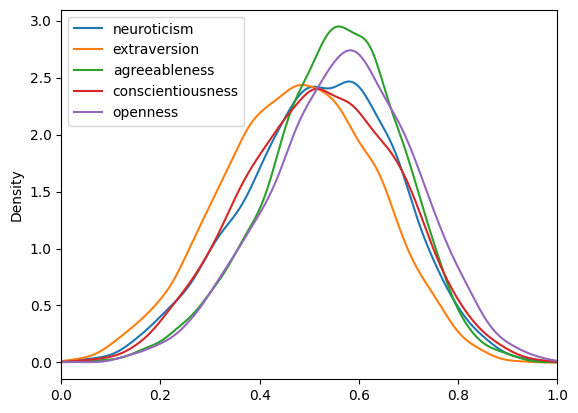

In [22]:
gt = pickle.load( open("annotation_training.pkl", "rb" ), encoding='latin1' )
neuroticism = list(gt['neuroticism'].values())
extraversion = list(gt['extraversion'].values())
agreeableness = list(gt['agreeableness'].values())
conscientiousness = list(gt['conscientiousness'].values())
openness = list(gt['openness'].values())

df = pd.DataFrame({'neuroticism': neuroticism,'extraversion': extraversion,'agreeableness':agreeableness,'conscientiousness':conscientiousness,'openness':openness})
df.plot(kind='density',xlim=(0,1))

In [23]:
df

,neuroticism,extraversion,agreeableness,conscientiousness,openness
0,0.552083,0.523364,0.626374,0.601942,0.488889
1,0.375000,0.345794,0.472527,0.582524,0.366667
2,0.291667,0.252336,0.406593,0.485437,0.511111
3,0.489583,0.457944,0.505495,0.398058,0.377778
4,0.489583,0.607477,0.406593,0.621359,0.622222
...,...,...,...,...,...
5995,0.479167,0.523364,0.626374,0.621359,0.544444
5996,0.760417,0.728972,0.582418,0.524272,0.822222
5997,0.770833,0.700935,0.747253,0.699029,0.788889
5998,0.531250,0.317757,0.582418,0.679612,0.588889


### Plotting number of samples in each set

In [24]:
print(len(train_set_data))
print(len(validation_set_data))
print(len(test_set_data))

6000
2000
2000


In [25]:
train_random_index = random.randint(0, len(train_set_data)-1)
validation_random_index = random.randint(0, len(validation_set_data)-1)
test_random_index = random.randint(0, len(test_set_data)-1)

In [26]:
shape = train_set_data[train_random_index][0].shape
mfcc_train = train_set_data[train_random_index][0].reshape(shape[0],shape[1])

shape = validation_set_data[validation_random_index][0].shape
mfcc_validation = validation_set_data[validation_random_index][0].reshape(shape[0],shape[1])

shape = test_set_data[test_random_index][0].shape
mfcc_train = test_set_data[test_random_index][0].reshape(shape[0],shape[1])

mfccs = [mfcc_train,mfcc_validation,mfcc_train]

### Displaying 3 video samples from train,validation and test sets

In [27]:
images_to_plot = []
images_to_plot.extend([(train_set_data[train_random_index][1])[i,:,:,:] for i in range(0,6)])
images_to_plot.extend([(validation_set_data[validation_random_index][1])[i,:,:,:] for i in range(0,6)])
images_to_plot.extend([(test_set_data[test_random_index][1])[i,:,:,:] for i in range(0,6)])
    

plt.figure(figsize=(18,11))

for i in range(18):
    plt.subplot(3,6,i+1)
    plt.imshow(images_to_plot[i])
plt.show()

ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 1800x1100 with 18 Axes>

### Displaying audio MFCC

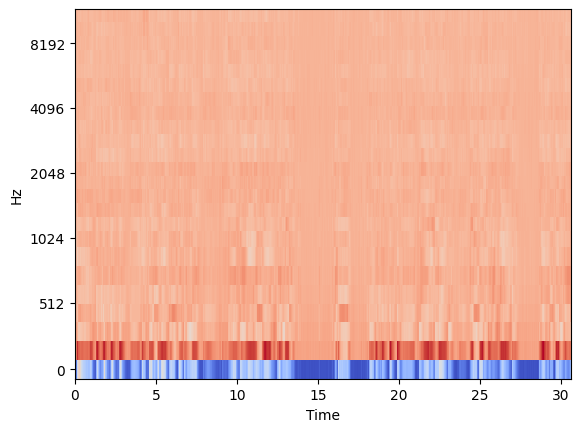

In [28]:
librosa.display.specshow(mfccs[0], x_axis='time', y_axis='mel')

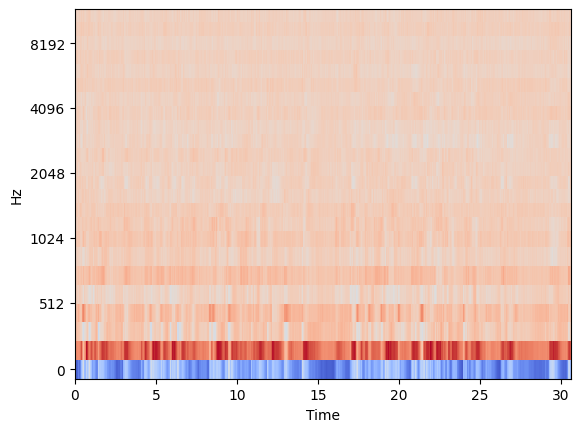

In [29]:
librosa.display.specshow(mfccs[1], x_axis='time', y_axis='mel')

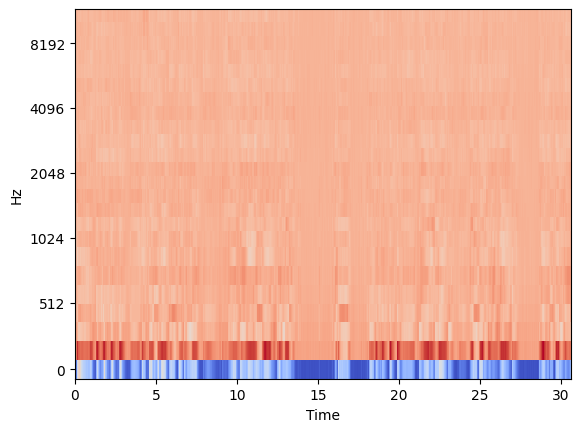

In [30]:
librosa.display.specshow(mfccs[2], x_axis='time', y_axis='mel')

### Printing personality traits

In [31]:
personality_train = train_set_data[train_random_index][2]
personality_validation = validation_set_data[validation_random_index][2]
personality_test = test_set_data[test_random_index][2]
personalities = ['Neuroticism','Extraversion','Agreeableness','Conscientiousness','Openness']

#### Train

In [32]:
for label, value in zip(personalities,personality_train):
    print(label + ': ' + str(value[0]))

Neuroticism: 0.24299065420560748
Extraversion: 0.37499999999999994
Agreeableness: 0.4615384615384615
Conscientiousness: 0.5048543689320388
Openness: 0.45555555555555555


#### Validation

In [33]:
for label, value in zip(personalities,personality_validation):
    print(label + ': ' + str(value[0]))

Neuroticism: 0.4299065420560748
Extraversion: 0.4375
Agreeableness: 0.6153846153846153
Conscientiousness: 0.6213592233009709
Openness: 0.43333333333333335


#### Test

In [34]:
for label, value in zip(personalities,personality_test):
    print(label + ': ' + str(value[0]))

Neuroticism: 0.5327102803738318
Extraversion: 0.5208333333333334
Agreeableness: 0.5164835164835165
Conscientiousness: 0.47572815533980584
Openness: 0.6444444444444444


### Converting sets to model format

In [35]:
def reshape_to_expected_input(dataset: List[Tuple[np.ndarray,np.ndarray,np.ndarray]]) -> Tuple[np.ndarray,np.ndarray,np.ndarray]:
    
    x0_list = []
    x1_list = []
    y_list = []
    for i in range(0,len(dataset)):
        x0_list.append(dataset[i][0])
        x1_list.append(dataset[i][1])
        y_list.append(dataset[i][2])
    return (np.stack(x0_list),np.stack(x1_list),np.stack(y_list))

In [36]:
train_input = reshape_to_expected_input(dataset= train_set_data)
del train_set_data
validation_input = reshape_to_expected_input(dataset= validation_set_data)
del validation_set_data
test_input = reshape_to_expected_input(dataset= test_set_data)
del test_set_data

## Creating Model

In [37]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, LSTM, Bidirectional, Lambda, Dropout, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import TimeDistributed

2025-04-27 16:17:51.200112: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-27 16:17:52.075243: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-27 16:17:53.629761: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Audio subnetwork

In [38]:
audio_input = Input(shape=(24,1319,1))
audio_model = Conv2D(32, kernel_size=(3,3),activation='relu')(audio_input)
audio_model = BatchNormalization()(audio_model)
audio_model = MaxPooling2D(pool_size=(2, 2))(audio_model)
audio_model = Conv2D(32, kernel_size=(3,3),activation='relu')(audio_model)
audio_model = BatchNormalization()(audio_model)
audio_model = MaxPooling2D(pool_size=(2, 2))(audio_model)
audio_model = Flatten()(audio_model)
audio_model = Dense(128, activation='relu')(audio_model)
audio_subnetwork = Model(inputs=audio_input,outputs=audio_model)

2025-04-27 16:17:59.436046: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-27 16:17:59.731380: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-27 16:17:59.733882: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Visual subnetwork

In [39]:
from keras.applications import vgg16

In [40]:
visual_model = Input(shape=(6,128,128,3))

cnn = vgg16.VGG16(weights="imagenet", include_top=False, pooling='max')
cnn.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [41]:
encoded_frame = TimeDistributed(Lambda(lambda x: cnn(x)))(visual_model)
encoded_vid = LSTM(64)(encoded_frame)

visual_subnetwork = Model(inputs=visual_model,outputs=encoded_vid)

In [42]:
combined = Concatenate()([audio_subnetwork.output, visual_subnetwork.output])
final1 = Dense(256, activation='relu')(combined)
final2 = Dense(5, activation='linear')(final1)

In [43]:
combined_network = Model(inputs=[audio_input, visual_model], outputs=final2)
combined_network.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 1319,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 22, 1317,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 22, 1317,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 11, 658,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 9, 656,    │      9,248 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 656,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 4, 328,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 6, 128,    │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 41984)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 6, 512)    │          0 │ input_layer_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  5,374,080 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │    147,712 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     49,408 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5)         │      1,285 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,582,309 (21.29 MB)

 Trainable params: 5,582,181 (21.29 MB)

 Non-trainable params: 128 (512.00 B)

In [44]:
combined_network.compile(optimizer = 'adam',loss = 'mean_absolute_error',metrics=['mae'])

### Training

In [45]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=10)

In [49]:
from keras.callbacks import ModelCheckpoint

# 定义保存最佳模型的回调函数
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # 保存路径
    monitor='val_loss',         # 监控验证集损失
    save_best_only=True,        # 仅保存性能最佳的模型
    mode='min',                 # 损失越小越好
    verbose=1
)

In [50]:
history = combined_network.fit(x = [train_input[0],train_input[1]],
                               y = train_input[2],
                               validation_data = ([validation_input[0],validation_input[1]],validation_input[2]),
                               epochs = 20,
                               verbose = 1,
                               callbacks = [early_stopping, checkpoint])

Epoch 1/20


2025-04-27 16:20:57.122650: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 1.5962 - mae: 1.5962
Epoch 1: val_loss improved from inf to 5.56221, saving model to best_model.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 106ms/step - loss: 1.5905 - mae: 1.5905 - val_loss: 5.5622 - val_mae: 5.5622
Epoch 2/20
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1133 - mae: 0.1133
Epoch 2: val_loss improved from 5.56221 to 0.23447, saving model to best_model.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - loss: 0.1133 - mae: 0.1133 - val_loss: 0.2345 - val_mae: 0.2345
Epoch 3/20
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1071 - mae: 0.1071
Epoch 3: val_loss improved from 0.23447 to 0.10819, saving model to best_model.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - loss: 0.1071 - mae: 0.1071 - val_loss: 0.1082 - val_mae: 0.1082
Epoch 4/20
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1005 - mae: 0.1005
Epoch 4: val_loss improved from 0.10819 to 0.10256, saving model to best_model.keras
188/188 ━━━━━━━━━━━

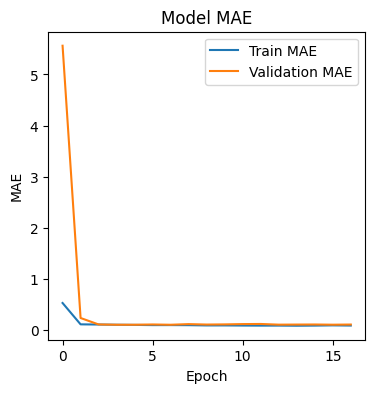

In [51]:
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train MAE', 'Validation MAE'], loc='upper right')

#### Evaluate model on train set

In [52]:
loss, mae = combined_network.evaluate([test_input[0],test_input[1]],test_input[2], verbose=0)

print('Test loss: {}'.format(loss))

Test loss: 0.1087961345911026


### 1-MAE

In [53]:
print('1-MAE: ' + str(1-mae))

1-MAE: 0.8912038654088974


In [54]:
one_minus_mae_train = [1-maee for maee in history.history['mae']]
one_minus_mae_val = [1-maee for maee in history.history['val_mae']]

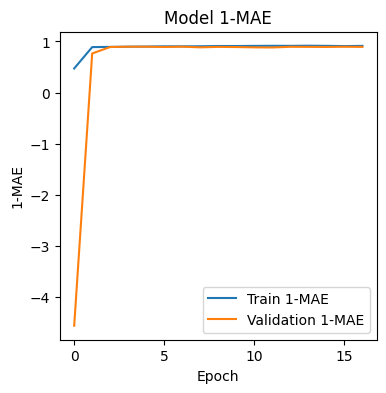

In [55]:
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(one_minus_mae_train)
plt.plot(one_minus_mae_val)
plt.title('Model 1-MAE')
plt.ylabel('1-MAE')
plt.xlabel('Epoch')
plt.legend(['Train 1-MAE', 'Validation 1-MAE'], loc='lower right')

### Coefficient of determination (R^2)

In [56]:
y_pred = combined_network.predict([test_input[0],test_input[1]])
pred_shape = y_pred.shape
y_pred = y_pred.reshape(pred_shape[0],pred_shape[1],1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step


In [57]:
normalized = y_pred / np.max(y_pred)

Text(0.5, 0, 'Y_pred_Neuroticism')

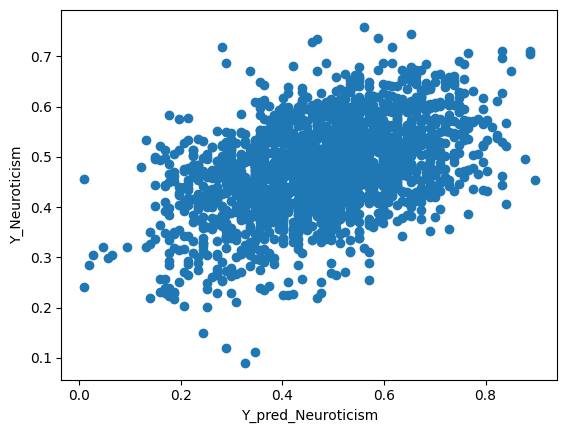

In [58]:
plt.scatter(test_input[2][:,0,:], normalized[:,0,:], marker='o');
plt.ylabel('Y_Neuroticism')
plt.xlabel('Y_pred_Neuroticism')

#### Coefficient Determination (R^2)

In [59]:
from sklearn.metrics import r2_score

In [60]:
pers = ['Neuroticism','Extraversion','Agreeableness','Conscientiousness','Openness']
r2s = [r2_score(test_input[2][:,i,:], normalized[:,i,:]) for i in range(5)]
for pers, r2 in zip(pers,r2s):
    print(pers + ': ' + str(r2))

Neuroticism: 0.18424635253631738
Extraversion: -0.013845751028852327
Agreeableness: -0.25084300759235045
Conscientiousness: -0.02713517553119038
Openness: 0.15220040067635254
